# E-Commerce Analysis

In [6]:
pip install pandas
pip install mysql-connector-python
pip install matplotlib
pip install seaborn
pip install plotly  # install Once

In [11]:
import pandas as pd
import os
import mysql.connector
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_item'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation') # Adding .csv for specific handling
]

In [15]:
conn = mysql.connector.connect(host ='localhost',
                              user = 'root',
                              password = 'admin',
                              database = 'ecommerce')
cursor = conn.cursor()

folder_path = r'C:\Users\hp\Downloads\E-commerce Analysis Dataset'

In [21]:
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

## List all unique cities where customers are located.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


conn = mysql.connector.connect(host ='localhost',
                              user = 'root',
                              password = 'admin',
                              database = 'ecommerce')

cursor = conn.cursor()

In [2]:
query = """ select distinct customer_city  from ecommerce.customers; """ 
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from ecommerce.orders where year(order_purchase_timestamp) =2017; """
cursor.execute(query)
data = cursor.fetchall()
data

"Total order placed in 2017", data[0][0]

('Total order placed in 2017', 45101)

## Find the total sales per category.

In [4]:
query = """ select products.product_category as Category, round(sum(payments.payment_value),2) as Sales
from ecommerce.products join ecommerce.order_item
on products.product_id = order_item.product_id join ecommerce.payments on order_item.order_id = payments.order_id
group by category;"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


## Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/ count(*)*100 from ecommerce.payments; """
cursor.execute(query)
data = cursor.fetchall()
data

"Percentage of order by installments", data[0][0]

('Percentage of order by installments', Decimal('99.9981'))

##  Count the number of customers from each state. 

<Axes: title={'center': 'Sales by each state'}, xlabel='State', ylabel='Count'>

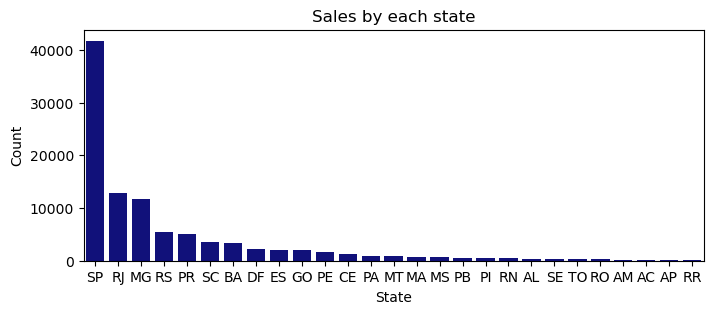

In [6]:
query = " select customer_state as state, count(customer_id) from ecommerce.customers group by state; "
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns =["State", "Count"])
df = df.sort_values(by = "Count", ascending= False)
plt.figure(figsize=(8, 3))
plt.title("Sales by each state")
sns.barplot(data=df, x= 'State', y = 'Count', color = 'darkBlue')

##  Count the number of customers from each City. 

In [7]:
query = " select  customer_city as city, count(customer_id) from ecommerce.customers group by city; "
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns =["Count", "city"])
df

,Count,city
0,franca,161
1,sao bernardo do campo,938
2,sao paulo,15540
3,mogi das cruzes,383
4,campinas,1444
...,...,...
4114,siriji,1
4115,natividade da serra,1
4116,monte bonito,1
4117,sao rafael,1


## Calculate the number of orders per month in 2018.

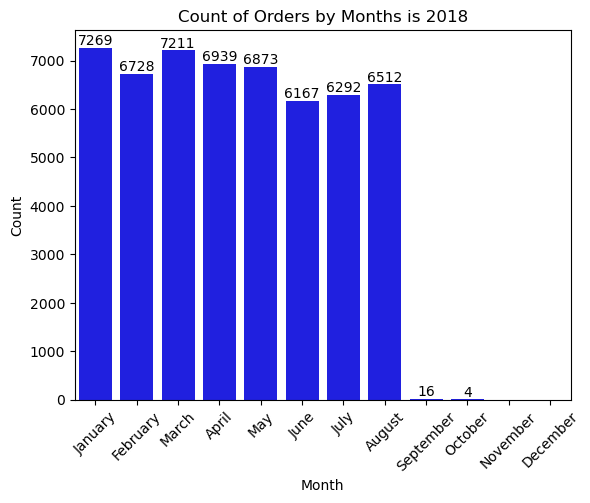

In [8]:
query = """ select monthname(order_purchase_timestamp) as month, count(order_id) as Count
from ecommerce.orders where year(order_purchase_timestamp) =2018 group by month; """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Month','Count'])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax =sns.barplot(data =df, x= df['Month'], y= df['Count'], order= o, color ='Blue')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()

## Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, Count(order_item.order_id) as order_count
from ecommerce.orders join ecommerce.order_item on orders.order_id = order_item.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city as city, round(avg(count_per_order.order_count),2) as average_order
from ecommerce.customers join count_per_order on 
customers.customer_id = count_per_order.customer_id
group by customers.customer_city; """

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['city','average_order'])
df

,city,average_order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


## Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_item
on products.product_id = order_item.product_id
join payments 
on payments.order_id = order_item.order_id
group by category order by sales_percentage desc;""" 
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['category', 'sales_percentage'])
df

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


## Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query = """ select products.product_category, count(order_item.product_id),
round(avg(order_item.price),2)  from ecommerce.products
join ecommerce.order_item on products.product_id = order_item.product_id
group by products.product_category;"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

df
import numpy as np

arr1 = df["order_count"]
arr2 = df["price"]
a= np.corrcoef([arr1,arr2])

"The correlation is", a[0][-1]

('The correlation is', -0.10631514167157562)

## Calculate the total revenue generated by each seller, and rank them by revenue.

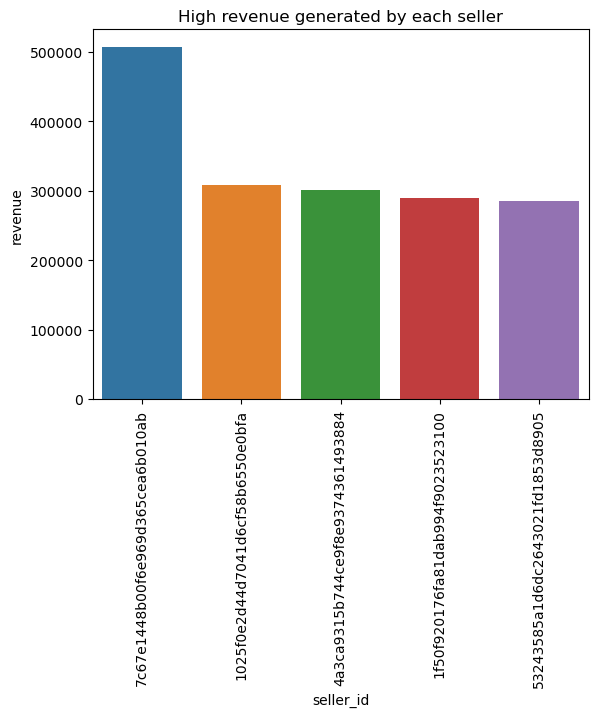

In [12]:
query ="""select *, dense_rank() over(order by revenue desc) as rn from
(select order_item.seller_id, sum(payments.payment_value)
revenue from ecommerce.order_item join ecommerce.payments
on order_item.order_id = payments.order_id
group by order_item.seller_id) as a;"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank of revenue"])
df = df.head()

sns.barplot(x = "seller_id", y  = "revenue", data =df)
plt.title("High revenue generated by each seller")
plt.xticks(rotation = 90)
plt.show()

## Calculate the cumulative sales per month for each year.

In [13]:
query = """select year, month, sales, sum(sales) over(order by year, month) as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as year, month(orders.order_purchase_timestamp) as month, 
round(sum(payments.payment_value),2) as sales
from ecommerce.orders join ecommerce.payments on payments.order_id = orders.order_id
group by year, month order by year, month asc) as a;"""

cursor.execute(query)
data = cursor.fetchall()
data
df= pd.DataFrame(data, columns = ["year", "month", "sales", "cumulative sales"])
df

,year,month,sales,cumulative sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## Calculate the year-over-year growth rate of total sales.


In [14]:
query = """ select year, sales, (sales-lag(sales,1) over(order by year))/ lag(sales,1) over(order by year)*100 from
(select year(orders.order_purchase_timestamp) as year,round(sum(payments.payment_value),2) as sales
from ecommerce.orders join ecommerce.payments on payments.order_id = orders.order_id
group by year order by year asc) as a;"""

cursor.execute(query)
data = cursor.fetchall()
data
df= pd.DataFrame(data, columns = ["year", "sales", "YOY Growth %"])
df

,year,sales,YOY Growth %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


## Identify the top 3 customers who spent the most money in each year

In [21]:
query = """ select year, customer, spent, d_rank from
(select year(orders.order_purchase_timestamp) as year, orders.customer_id as customer, sum(payments.payment_value) Spent, 
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from ecommerce.orders join ecommerce.payments on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id 
order by year asc) as a where d_rank <= 3;"""

cursor.execute(query)
data = cursor.fetchall()
data
df= pd.DataFrame(data, columns = ["year", "customer", "spent","Rank"])
df


,year,customer,spent,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3
